In [17]:
import numpy as np
import datetime as dt
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import dask
dask.config.set(scheduler='synchronous')
#from dask.distributed import Client, LocalCluster
#cluster = LocalCluster(processes=True)
#client = Client(cluster)  # memory_limit='16GB', 

import xarray as xr
from dask.diagnostics import ProgressBar

import numpy as np
import datetime as dt
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


#import joblib
from sklearn.pipeline import Pipeline
#from dask_ml.preprocessing import StandardScaler
#from dask_ml.decomposition import PCA

#from dask_ml.xgboost import XGBRegressor
#from dask_ml.linear_model import LogisticRegression
#from dask_ml.linear_model import LinearRegression
#from sklearn.linear_model import Ridge

import keras
from keras.layers.core import Dropout

Using TensorFlow backend.


ImportError: Traceback (most recent call last):
  File "/home/srvx11/lehre/users/a1303583/.conda/envs/ml_flood/lib/python3.7/site-packages/tensorflow/python/pywrap_tensorflow.py", line 58, in <module>
    from tensorflow.python.pywrap_tensorflow_internal import *
  File "/home/srvx11/lehre/users/a1303583/.conda/envs/ml_flood/lib/python3.7/site-packages/tensorflow/python/pywrap_tensorflow_internal.py", line 28, in <module>
    _pywrap_tensorflow_internal = swig_import_helper()
  File "/home/srvx11/lehre/users/a1303583/.conda/envs/ml_flood/lib/python3.7/site-packages/tensorflow/python/pywrap_tensorflow_internal.py", line 24, in swig_import_helper
    _mod = imp.load_module('_pywrap_tensorflow_internal', fp, pathname, description)
  File "/home/srvx11/lehre/users/a1303583/.conda/envs/ml_flood/lib/python3.7/imp.py", line 242, in load_module
    return load_dynamic(name, filename, file)
  File "/home/srvx11/lehre/users/a1303583/.conda/envs/ml_flood/lib/python3.7/imp.py", line 342, in load_dynamic
    return _load(spec)
ImportError: /home/srvx11/lehre/users/a1303583/.conda/envs/ml_flood/lib/python3.7/site-packages/tensorflow/python/../../_solib_k8/_U@mkl_Ulinux_S_S_Cmkl_Ulibs_Ulinux___Uexternal_Smkl_Ulinux_Slib/libmklml_intel.so: symbol __kmpc_omp_task_with_deps, version VERSION not defined in file libiomp5.so with link time reference


Failed to load the native TensorFlow runtime.

See https://www.tensorflow.org/install/errors

for some common reasons and solutions.  Include the entire stack trace
above this error message when asking for help.

In [ ]:
import sys
print(sys.executable)

In [ ]:
def shift_time(ds, value):
    ds.coords['time'].values = pd.to_datetime(ds.coords['time'].values) + value
    return ds

# select data

In [ ]:
static = xr.open_dataset('../data/danube/era5_slt_z_slor_lsm_stationary_field.nc')
print(static)
glofas = xr.open_dataset('../data/danube/glofas_reanalysis_danube_1981-2002.nc')
glofas = glofas.rename({'lat': 'latitude', 'lon': 'longitude'})  # to have the same name like in era5
glofas = shift_time(glofas, -dt.timedelta(days=1))
z_glofas = static['z'].isel(time=0)/9.81  # converting to m approx.
z_glofas = z_glofas.interp(latitude=glofas.latitude,
                           longitude=glofas.longitude)
print(z_glofas)
dis = glofas['dis']
print(dis)

In [ ]:
plt.figure(figsize=(26,6))
i = 48.45
j = 13.75
z_point = z_glofas.sel(latitude=slice(i, i-0.01)).sel(longitude=slice(j, j+0.01))

z_glofas.plot()

# river mask
river = dis.min('time') > 5
river.name = 'river mask [0/1]'
dis.mean('time').where(river).plot(cmap='RdBu')
#dis.mean('time').plot(cmap='RdBu')

ax = plt.gca()
p = plt.scatter(j, i, s=1500, marker='o', lw=10, facecolor='none', color='cyan')




In [ ]:
plt.figure(figsize=(26,6))
i = 48.45
j = 13.75
z_point = z_glofas.sel(latitude=slice(i, i-0.01)).sel(longitude=slice(j, j+0.01))

z_glofas.where(z_glofas.values >= z_point.values).plot()
dis.mean('time').where(river).plot(cmap='RdBu')

ax = plt.gca()
p = plt.scatter(j, i, s=1500, marker='o', lw=10, facecolor='none', color='cyan')

In [ ]:
plt.figure(figsize=(26,6))
i = 48.45
j = 13.75
z_point = z_glofas.sel(latitude=slice(i, i-0.01)).sel(longitude=slice(j, j+0.01))

z_glofas.where(z_glofas.values >= z_point.values-150).plot()
dis.mean('time').where(river).plot(cmap='RdBu')

ax = plt.gca()
p = plt.scatter(j, i, s=1500, marker='o', lw=10, facecolor='none', color='cyan')

In [ ]:
dis_point = dis.where(z_point).squeeze()
dis_point

In [ ]:
def correlate(da_3d, da_timeseries, timelag=False):
    a = da_3d - da_3d.mean('time')
    b = da_timeseries - da_timeseries.mean('time')
    N = len(b.coords['time'])
    if timelag:
        b = b.drop('time')
        a = a.drop('time')
#    out = b.dot(a)/a.std('time')/b.std()/N
    out = np.zeros(a.isel(time=1).shape)*np.nan
    i = 0
    for lat in a.latitude:
        j = 0
        for lon in a.longitude:
            a_iter = a.sel(latitude=lat, longitude=lon)
            out[i,j] = np.corrcoef(a_iter, b)[0,1]
            j += 1
        i += 1
    out = xr.DataArray(out, dims=['latitude', 'longitude'], coords=[a.latitude, a.longitude])
    out.name = 'correlation coefficient'
    return out

In [ ]:
plt.figure(figsize=(26,6))
i = 48.45
j = 13.75
z_point = z_glofas.sel(latitude=slice(i, i-0.01)).sel(longitude=slice(j, j+0.01))

z_glofas.where(z_glofas.values >= z_point.values-150).plot()
#dis.mean('time').where(river).plot(cmap='RdBu')

ax = plt.gca()
p = plt.scatter(j, i, s=1500, marker='o', lw=10, facecolor='none', color='cyan')


a = correlate(dis.where(river), dis_point)
a.plot(cmap='rainbow')


In [18]:
def correlate(da_3d, da_timeseries, timelag=False):
    a = da_3d - da_3d.mean('time')
#    a = da_3d
    b = da_timeseries - da_timeseries.mean('time')
#    b = da_timeseries
    N = len(b.coords['time'])
    if timelag:
        b = b.drop('time')
        a = a.drop('time')
#    out = b.dot(a)/a.std('time')/b.std()/N
    out = np.zeros(a.isel(time=1).shape)*np.nan
    i = 0
    for lat in a.latitude:
        j = 0
        for lon in a.longitude:
            a_iter = a.sel(latitude=lat, longitude=lon)
            out[i,j] = np.corrcoef(a_iter, b)[0,1]
            j += 1
        i += 1
    out = xr.DataArray(out, dims=['latitude', 'longitude'], coords=[a.latitude, a.longitude])
    out.name = 'correlation coefficient'
    return out

In [19]:
lags = [-1, 1]

timelag_corrs = np.full((len(lags), dis.latitude.shape[0], dis.longitude.shape[0]), np.nan)
for t, lag in enumerate(lags):
    if lag > 0:  # dis_box with data from previous timesteps
        dis_point_lag = dis.where(z_point).squeeze()[lag:]
        dis_box = dis.where(river)[:-lag]
    elif lag < 0:  # dis_box with data from future timesteps
        dis_point_lag = dis.where(z_point).squeeze()[:lag]
        dis_box = dis.where(river)[-lag:]
        
    timelag_corrs[t,:,:] = correlate(dis_box, dis_point_lag, timelag=True)


lag_influencing = timelag_corrs[1,:,:] > timelag_corrs[0,:,:]

NameError: name 'z_point' is not defined

/home/srvx11/lehre/users/a1303583/.conda/envs/ml_flood/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in greater
  del sys.path[0]
/home/srvx11/lehre/users/a1303583/.conda/envs/ml_flood/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in less


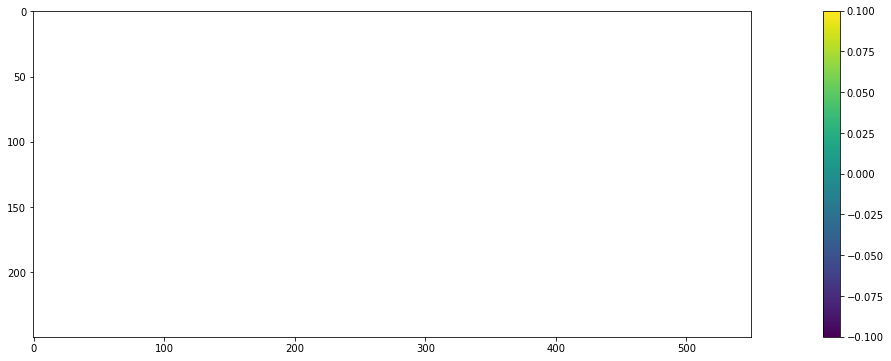

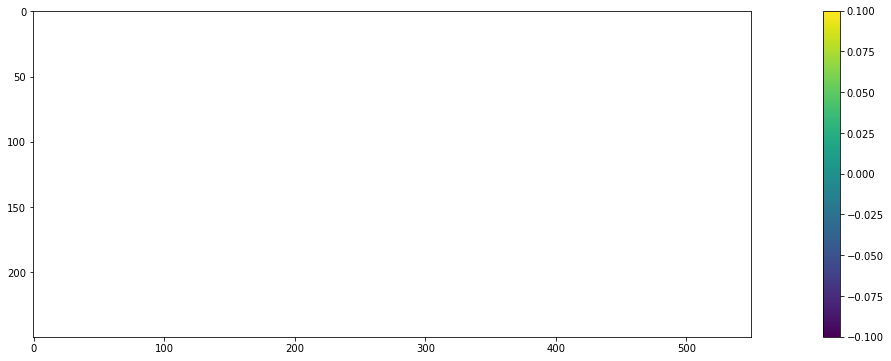

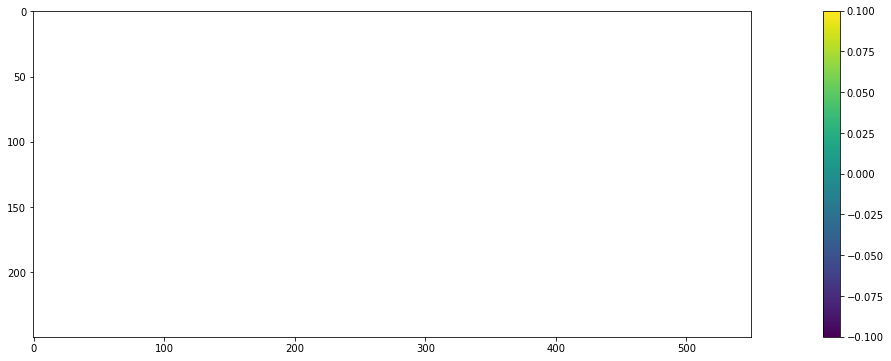

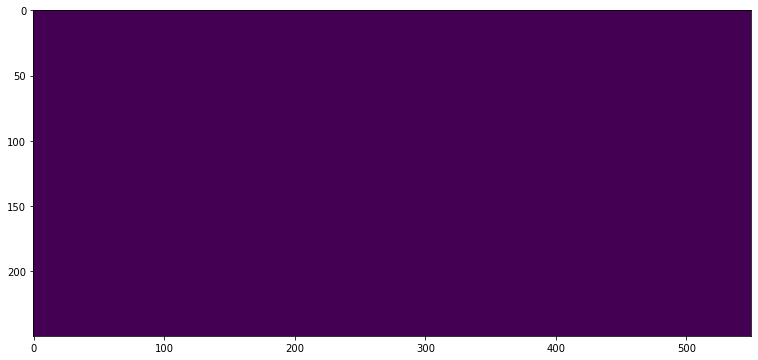

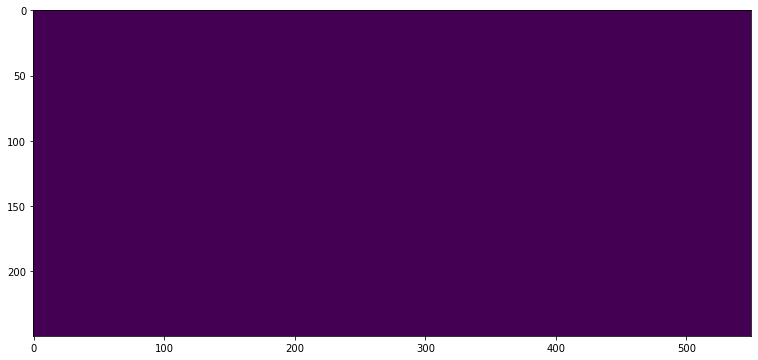

In [20]:
plt.figure(figsize=(26,6))
plt.imshow(timelag_corrs[0,:,:])
plt.colorbar()

plt.figure(figsize=(26,6))
plt.imshow(timelag_corrs[1,:,:])
plt.colorbar()

plt.figure(figsize=(26,6))
plt.imshow(timelag_corrs[0,:,:] - timelag_corrs[1,:,:])
plt.colorbar()

lag_influencing = timelag_corrs[1,:,:] > timelag_corrs[0,:,:]
plt.figure(figsize=(26,6))
plt.imshow(lag_influencing)

lag_influencing = timelag_corrs[1,:,:] < timelag_corrs[0,:,:]
plt.figure(figsize=(26,6))
plt.imshow(lag_influencing)

In [21]:
lag_influencing

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

# investigate single constraints

In [22]:
plt.figure(figsize=(26,6))
dis_box_mean = dis.mean('time')
dis_box_mean.where(dis_box_mean > 50).plot()

mask_box_mean_greater = (~np.isnan(dis_box_mean.where(dis_box_mean > 50))).astype(bool)

MemoryError: 

<Figure size 1872x432 with 0 Axes>

In [ ]:
plt.figure(figsize=(26,6))
z_river = z_glofas.where(river)
z_river.where(z_river > z_point.squeeze()-100).plot()

mask_river_altitude_greater = (~np.isnan(z_river.where(z_river > z_point.squeeze()-100))).astype(bool)

In [ ]:
plt.figure(figsize=(26,6))
(dis_box_mean > pct*dis_box_mean.sel(latitude=dis_point.latitude, longitude=dis_point.longitude)).plot()

mask_mean_greater_pct_point = (dis_box_mean > pct*dis_box_mean.sel(latitude=dis_point.latitude, longitude=dis_point.longitude)).astype(bool)

In [ ]:
plt.figure(figsize=(26,6))
plt.imshow(lag_influencing > 0.9)

mask_lag_greater = (lag_influencing > 0.9).astype(bool)

In [ ]:
pct = 0.2
# select feature gridpoints
plt.figure(figsize=(26,6))
influencer = (dis_box_mean > pct*dis_box_mean.sel(latitude=dis_point.latitude, longitude=dis_point.longitude))  \
                &(river==1) & (lag_influencing > 0.5) \
                &(z_glofas.where(z_glofas >= z_point.squeeze()-50)).astype(bool)
               
influencer.name = 'gridpoints influencing discharge [0/1]'
influencer.plot()

In [ ]:
plt.figure(figsize=(26,6))
z_glofas.where(z_glofas > z_point.squeeze()-100).plot()

mask_z_greater = (~np.isnan(z_glofas.where(z_glofas > z_point.squeeze()-100))).astype(bool)

In [23]:
mask_box_mean_greater
mask_river_altitude_greater
mask_mean_greater_pct_point
mask_lag_greater
mask_z_greater

NameError: name 'mask_river_altitude_greater' is not defined

In [ ]:
plt.figure(figsize=(26,6))
dis_box_mean.where(mask_box_mean_greater).plot()
plt.figure(figsize=(26,6))
dis_box_mean.where(mask_river_altitude_greater).plot()
plt.figure(figsize=(26,6))
dis_box_mean.where(mask_mean_greater_pct_point).plot()
plt.figure(figsize=(26,6))
dis_box_mean.where(mask_lag_greater).plot()
plt.figure(figsize=(26,6))
dis_box_mean.where(mask_z_greater).plot()

In [ ]:
plt.figure(figsize=(26,6))
dis_box_mean.where(mask_box_mean_greater & mask_river_altitude_greater \
                   &mask_lag_greater & mask_z_greater & mask_mean_greater_pct_point).plot()

p = plt.scatter(j, i, s=1500, marker='o', lw=10, facecolor='none', color='cyan')

In [ ]:
plt.figure(figsize=(26,6))
z_river = z_glofas.where(river)
z_river.where(z_river > z_point.squeeze()-100).plot()

In [ ]:
dis_point

In [ ]:
import geopandas
from rasterio import features
from affine import Affine

def filter_data_inside_single_basin(da, kw_basins='Danube'):
    def transform_from_latlon(lat, lon):
        lat = np.asarray(lat)
        lon = np.asarray(lon)
        trans = Affine.translation(lon[0], lat[0])
        scale = Affine.scale(lon[1] - lon[0], lat[1] - lat[0])
        return trans * scale

    def rasterize(shapes, coords, fill=np.nan, **kwargs):
        """Rasterize a list of (geometry, fill_value) tuples onto the given
        xray coordinates. This only works for 1d latitude and longitude
        arrays.
        """
        transform = transform_from_latlon(coords['latitude'], coords['longitude'])
        out_shape = (len(coords['latitude']), len(coords['longitude']))
        raster = features.rasterize(shapes, out_shape=out_shape,
                                    fill=fill, transform=transform,
                                    dtype=float, **kwargs)
        return xr.DataArray(raster, coords=coords, dims=('latitude', 'longitude'))
    
    # this shapefile is from natural earth data
    # http://www.naturalearthdata.com/downloads/10m-cultural-vectors/10m-admin-1-states-provinces/
    shp2 = '/raid/home/srvx7/lehre/users/a1303583/ipython/ml_flood/data/drainage_basins/Major_Basins_of_the_World.shp'
    basins = geopandas.read_file(shp2)
#    print(basins)
    single_basin = basins.query("NAME == '"+kw_basins+"'").reset_index(drop=True)
#    print(single_basin)
    shapes = [(shape, n) for n, shape in enumerate(single_basin.geometry)]

    da['basins'] = rasterize(shapes, da.coords)
    return da.where(da.basins == 0)

In [ ]:
z_danube = filter_data_inside_single_basin(z_glofas, kw_basins='Danube')
mask_danube_basin = ~np.isnan(z_danube).astype(bool)

# spatial feature selection

In [ ]:
plt.figure(figsize=(26,6))
z_danube.plot()
p = plt.scatter(j, i, s=1500, marker='o', lw=10, facecolor='none', color='cyan')

In [ ]:
z_downstream = z_glofas.where(z_glofas.longitude <= j)
mask_downstream = ~np.isnan(z_downstream).astype(bool)

plt.figure(figsize=(26,6))
z_glofas.where(mask_downstream).plot()
p = plt.scatter(j, i, s=1500, marker='o', lw=10, facecolor='none', color='cyan')

In [ ]:
z_downstream = z_glofas.where(z_glofas >= z_point.squeeze())
z_downstream = z_downstream.where(z_glofas.longitude >= j)
mask_downstream = ~np.isnan(z_downstream).astype(bool)

plt.figure(figsize=(26,6))
z_glofas.where(mask_downstream).plot()
p = plt.scatter(j, i, s=1500, marker='o', lw=10, facecolor='none', color='cyan')

In [ ]:
plt.figure(figsize=(26,6))
dis_box_mean.where(mask_box_mean_greater).plot()

p = plt.scatter(j, i, s=1500, marker='o', lw=10, facecolor='none', color='cyan')

In [ ]:
plt.figure(figsize=(26,6))
z_danube.plot()
dis_box_mean.where(mask_box_mean_greater & mask_danube_basin & mask_downstream).plot(cmap='rainbow')

p = plt.scatter(j, i, s=1500, marker='o', lw=10, facecolor='none', color='cyan')

In [ ]:
dis_point.plot()

# USA exemplary 

<xarray.Dataset>
Dimensions:    (latitude: 101, longitude: 221, time: 744)
Coordinates:
  * longitude  (longitude) float32 -125.0 -124.75 -124.5 ... -70.5 -70.25 -70.0
  * latitude   (latitude) float32 50.0 49.75 49.5 49.25 ... 25.5 25.25 25.0
  * time       (time) datetime64[ns] 2017-01-01 ... 2017-01-31T23:00:00
Data variables:
    slor       (time, latitude, longitude) float32 ...
    lsm        (time, latitude, longitude) float32 ...
    slt        (time, latitude, longitude) float32 ...
    z          (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2019-05-29 15:32:37 GMT by grib_to_netcdf-2.10.0: /opt/ecmw...
<xarray.DataArray 'z' (latitude: 250, longitude: 550)>
array([[ 1.033807e+02,  1.295250e+02,  1.556693e+02, ...,  4.951622e+02,
         4.973871e+02,  4.996119e+02],
       [ 1.442023e+02,  1.641796e+02,  1.841568e+02, ...,  4.795543e+02,
         4.817030e+02,  4.838518e+02],
       [ 1.850239e+02,  1.988342e+02,  2.126444e+02

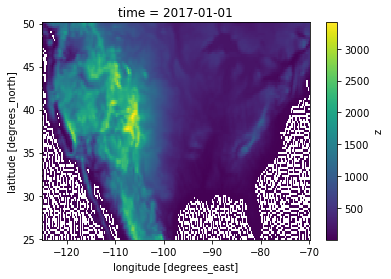

In [5]:
static = xr.open_dataset('../data/usa/era5_slt_z_slor_lsm_stationary_field.nc')
print(static)
alti = static['z'].isel(time=0)/9.81
glofas = xr.open_dataset('../data/usa/glofas_reanalysis_usa_1981-2002.nc')
glofas = glofas.rename({'lat': 'latitude', 'lon': 'longitude'})  # to have the same name like in era5
glofas = shift_time(glofas, -dt.timedelta(days=1))
z_glofas = static['z'].isel(time=0)/9.81  # converting to m approx.
z_glofas = z_glofas.interp(latitude=glofas.latitude,
                           longitude=glofas.longitude)
print(z_glofas)
dis = glofas['dis']
print(dis)
alti.where(alti > 0).plot.imshow()

In [6]:
j = -92
i = 31
point = (i, j)
alti.sel(latitude=point[0], longitude=point[1])

<xarray.DataArray 'z' ()>
array(20.876736, dtype=float32)
Coordinates:
    longitude  float32 -92.0
    latitude   float32 31.0
    time       datetime64[ns] 2017-01-01

In [7]:
import geopandas
from rasterio import features
from affine import Affine

def filter_data_inside_single_basin(da, kw_basins='Danube'):
    def transform_from_latlon(lat, lon):
        lat = np.asarray(lat)
        lon = np.asarray(lon)
        trans = Affine.translation(lon[0], lat[0])
        scale = Affine.scale(lon[1] - lon[0], lat[1] - lat[0])
        return trans * scale

    def rasterize(shapes, coords, fill=np.nan, **kwargs):
        """Rasterize a list of (geometry, fill_value) tuples onto the given
        xray coordinates. This only works for 1d latitude and longitude
        arrays.
        """
        transform = transform_from_latlon(coords['latitude'], coords['longitude'])
        out_shape = (len(coords['latitude']), len(coords['longitude']))
        raster = features.rasterize(shapes, out_shape=out_shape,
                                    fill=fill, transform=transform,
                                    dtype=float, **kwargs)
        return xr.DataArray(raster, coords=coords, dims=('latitude', 'longitude'))
    
    # this shapefile is from natural earth data
    # http://www.naturalearthdata.com/downloads/10m-cultural-vectors/10m-admin-1-states-provinces/
    shp2 = '/raid/home/srvx7/lehre/users/a1303583/ipython/ml_flood/data/drainage_basins/Major_Basins_of_the_World.shp'
    basins = geopandas.read_file(shp2)
#    print(basins)
    single_basin = basins.query("NAME == '"+kw_basins+"'").reset_index(drop=True)
#    print(single_basin)
    shapes = [(shape, n) for n, shape in enumerate(single_basin.geometry)]

    da['basins'] = rasterize(shapes, da.coords)
    return da.where(da.basins == 0)

In [8]:
z_mississippi = filter_data_inside_single_basin(z_glofas, kw_basins='Mississippi')
mask_mississippi_basin = ~np.isnan(z_mississippi).astype(bool)

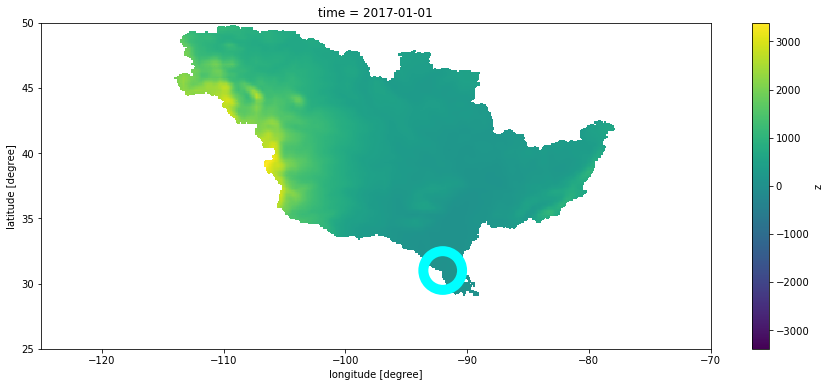

In [9]:
plt.figure(figsize=(15,6))
z_mississippi.plot(cmap='viridis')
p = plt.scatter(j, i, s=1500, marker='o', lw=10, facecolor='none', color='cyan')

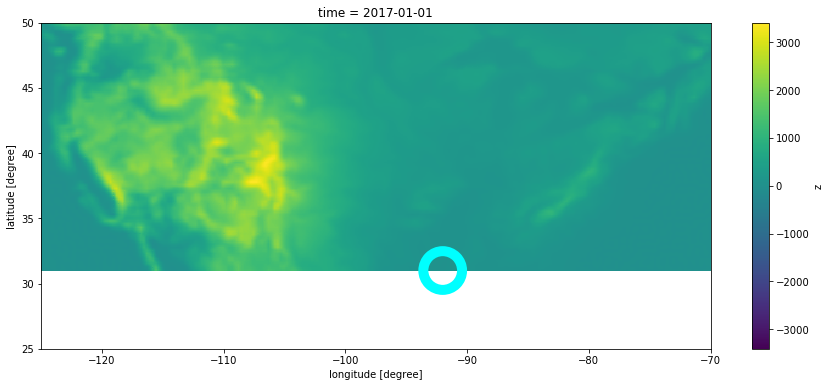

In [10]:
z_downstream = z_glofas.where(z_glofas.latitude >= i)
mask_downstream = ~np.isnan(z_downstream).astype(bool)

plt.figure(figsize=(15,6))
z_glofas.where(mask_downstream).plot(cmap='viridis')
p = plt.scatter(j, i, s=1500, marker='o', lw=10, facecolor='none', color='cyan')

In [11]:
dis_usa = glofas['dis']
dis_usa_mean = dis_usa[:1000].mean('time')

/home/srvx11/lehre/users/a1303583/.conda/envs/ml_flood/lib/python3.7/site-packages/xarray/core/nanops.py:160: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


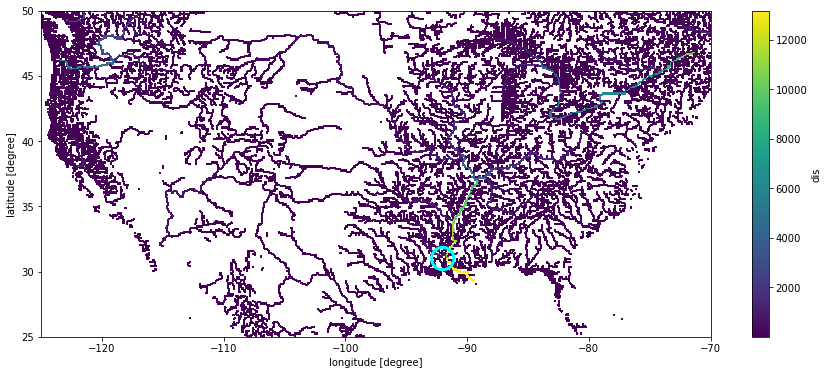

In [12]:
plt.figure(figsize=(15,6))
#dis_usa_mean.where(dis_usa_mean > 100).plot(cmap='RdBu')
mask_box_mean_greater = (~np.isnan(dis_usa_mean.where(dis_usa_mean > 5))).astype(bool)

dis_usa_mean.where(mask_box_mean_greater).plot(cmap='viridis')

p = plt.scatter(j, i, s=500, marker='o', lw=3, facecolor='none', color='cyan')

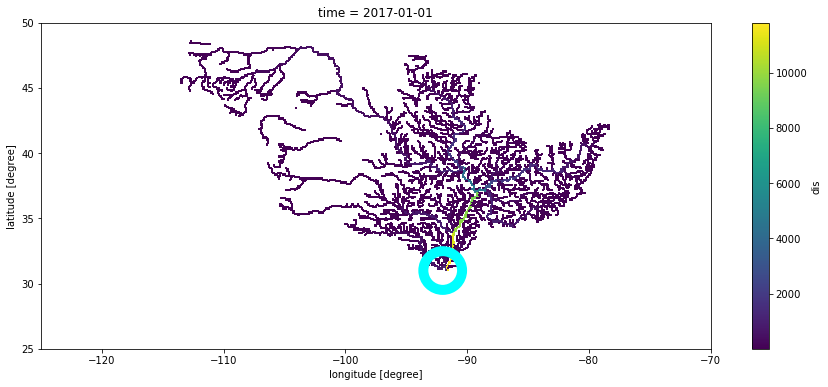

In [13]:
plt.figure(figsize=(15,6))
dis_usa_mean.where(mask_box_mean_greater & mask_mississippi_basin & mask_downstream).plot()

p = plt.scatter(j, i, s=1500, marker='o', lw=10, facecolor='none', color='cyan')

In [14]:
def add_shifted_predictors(ds, shifts, variables='all'):
    """Adds additional variables to an array which are shifted in time.
    
    Parameters
    ----------
    ds : xr.Dataset
    shifts : list of integers
    variables : str or list
    """
    if variables == 'all': 
        variables = ds.data_vars
        
    for var in variables:
        for i in shifts:
            if i == 0: continue  # makes no sense to shift by zero
            newvar = var+'-'+str(i)
            ds[newvar] = ds[var].shift(time=i)
    return ds

In [15]:
shifts = range(1,4)
X_dis = add_shifted_predictors(glofas, shifts, variables='all')
X_dis = X_dis.drop('dis')  # we actually want to predict (t) with (t-1, t-2, t-3)
y_dis = glofas['dis']

MemoryError: 

In [59]:
def preprocess_reshape(X_dis, y_dis, i, j):
    """Reshape, merge predictor/predictand in time, drop nans."""
    X_dis = X_dis.to_array(dim='time_feature')  
    X_dis = X_dis.stack(features=['latitude', 'longitude', 'time_feature'])
    Xar = X_dis.dropna('features', how='all')
    
    yar = y_dis[:,i,j]
    yar = yar.drop(['latitude', 'longitude'])
    yar.coords['features'] = 'dis'
    
    Xy = xr.concat([Xar, yar], dim='features')
    Xyt = Xy.dropna('time', how='any')  # drop them as we cannot train on nan values
    time = Xyt.time
    
    Xda = Xyt[:,:-1]
    yda = Xyt[:,-1]
    return Xda, yda, time

In [25]:
# space subset, dimensionality reduction
#X_dis = X_dis.where(upstream)

# time subset
X_dis = X_dis.where(noprecip)
y_dis = y_dis.where(noprecip)
    
Xda, yda, time = preprocess_reshape(X_dis, y_dis, i,j)

In [26]:
N_train = 365*3
N_valid = 365

X_train = Xda[:N_train,:]
y_train = yda[:N_train]
X_valid = Xda[N_train:N_train+N_valid,:]
y_valid = yda[N_train:N_train+N_valid]

print(Xda.shape)
print('train shapes:', X_train.shape, y_train.shape)
print('valid shapes:', X_valid.shape, y_valid.shape)

(2392, 78)
train shapes: (1095, 78) (1095,)
valid shapes: (365, 78) (365,)


In [27]:
def add_time(vector, time, name=None):
    """Converts arrays to xarrays with a time coordinate."""
    return xr.DataArray(vector, dims=('time'), coords={'time': time}, name=name)

class KerasDenseNN(object):
    def __init__(self, **kwargs):
        model = keras.models.Sequential()
        self.cfg = kwargs
        
        model.add(keras.layers.BatchNormalization())
        
        model.add(keras.layers.Dense(8,
                                  kernel_initializer='normal', 
                                  bias_initializer='zeros',
                                  activation='relu')) #('sigmoid'))
        #model.add(Dropout(self.cfg.get('dropout')))
        #model.add(keras.layers.Dense(32))
        #model.add(keras.layers.Activation('sigmoid'))
        #model.add(Dropout(self.cfg.get('dropout')))
        #model.add(keras.layers.Dense(16))
        #model.add(keras.layers.Activation('sigmoid'))
        #model.add(Dropout(self.cfg.get('dropout')))
        #model.add(keras.layers.Dense(8))
        #model.add(keras.layers.Activation('sigmoid'))
        #model.add(Dropout(self.cfg.get('dropout')))
        model.add(keras.layers.Dense(1, activation='linear'))
        #                     bias_initializer=keras.initializers.Constant(value=9000)))
        
        #ha = self.cfg.get('hidden_activation')

        #for N_nodes in self.cfg.get('N_hidden_nodes'):
        #        
        #    model.add(hidden)
        #    model.add(ha.copy())
        #    
        #    if self.cfg.get('dropout'):
        #        model.add(Dropout(self.cfg.get('dropout')))#

        #outputlayer = keras.layers.Dense(1, activation='linear')

        #optimizer_name, options_dict = self.cfg.get('optimizer')
        #optimizer = getattr(keras.optimizers, optimizer_name)(**options_dict)
        #optimizer = keras.optimizers.SGD(lr=0.01)
        rmsprop = keras.optimizers.RMSprop(lr=.1)
        sgd = keras.optimizers.SGD(lr=0.1, decay=1e-6, momentum=0.5, nesterov=True)

        model.compile(loss=self.cfg.get('loss'), 
                      optimizer=rmsprop)
        self.model = model

        self.callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss',
                            min_delta=1, patience=100, verbose=0, mode='auto',
                            baseline=None, restore_best_weights=True),]

    def predict(self, Xda, name=None):
        a = self.model.predict(Xda.values).squeeze()
        return add_time(a, Xda.time, name=name)

    def fit(self, Xda, yda, **kwargs):
        return self.model.fit(Xda.values, yda.values.reshape(-1,1),
                              epochs=self.cfg.get('epochs', None),
                              batch_size=self.cfg.get('batch_size', None),
                              callbacks=self.callbacks,
                              verbose=0,
                              **kwargs)

In [28]:
mlp_kws = dict(optimizer=('sgd', dict(lr=1)),
               loss='mean_squared_error',
               #N_hidden_nodes=(4,4),
               #hidden_activation=keras.layers.Activation('sigmoid'), #keras.layers.ReLU(), #-LeakyReLU(alpha=0.3), #'relu',
               #output_activation='linear',
               #bias_initializer='random_uniform',
               batch_size=128,
               dropout=0., #.25,
               epochs=1000,
              )


linear_kws = dict(C=.1, n_jobs=-1, max_iter=10000, verbose=True)


if False:
    pipe = Pipeline([('scaler', StandardScaler()),
                     ('pca', PCA(n_components=4)),
                     ('model', LinearRegression(**linear_kws)),],
                    verbose=True)
if True:
    pipe = Pipeline([#('scaler', StandardScaler()),
                     #('pca', PCA(n_components=2)),
                     ('model', KerasDenseNN(**mlp_kws)),],
                    verbose=False)
    

In [29]:
pipe

Pipeline(memory=None,
         steps=[('model', <__main__.KerasDenseNN object at 0x7f5b722e1da0>)],
         verbose=False)

In [30]:
history = pipe.fit(X_train, y_train,
                   model__validation_data=(X_valid, #.values, 
                                           y_valid)) #.values.reshape(-1,1)))

In [31]:
keras.utils.print_summary(pipe.named_steps['model'].model)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_1 (Batch (None, 78)                312       
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 632       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 9         
Total params: 953
Trainable params: 797
Non-trainable params: 156
_________________________________________________________________


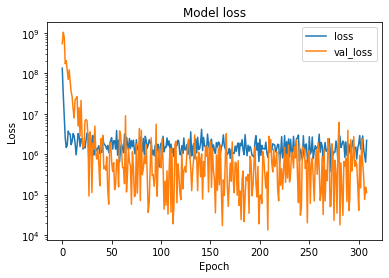

In [32]:
h = history.named_steps['model'].model.history

# Plot training & validation loss values
plt.plot(h.history['loss'], label='loss')
plt.plot(h.history['val_loss'], label='val_loss')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend() #['Train', 'Test'], loc='upper left')
plt.gca().set_yscale('log')
plt.show()

# Test it on the same data

In [33]:
y_train_pred = pipe.predict(X_train, name='dis-fcst-train')
y_valid_pred = pipe.predict(X_valid, name='dis-fcst-valid')

In [34]:
X_valid.values.shape

(365, 78)

(723181.0, 726629.0)

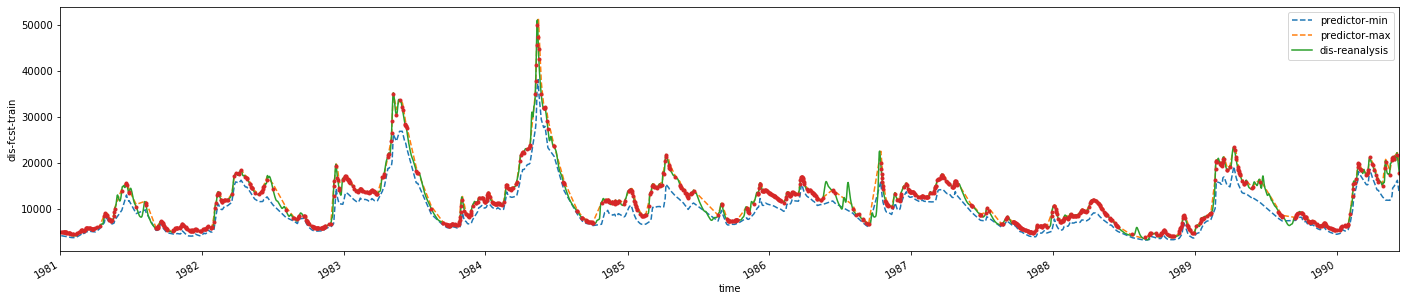

In [42]:
fig, ax = plt.subplots(figsize=(24,5))
minpred = X_train.min('features')
maxpred = X_train.max('features')

minpred.plot(ax=ax, linestyle='--', label='predictor-min')
maxpred.plot(ax=ax, linestyle='--', label='predictor-max')


dis[:,i,j].to_pandas().plot(ax=ax, label='dis-reanalysis')
y_train_pred.plot(ax=ax, marker='.', lw=0)

plt.legend()
plt.gca().set_xlim(dt.datetime(1981,1,1), y_train_pred.time.values[-1]) 

(726630.0, 727717.0)

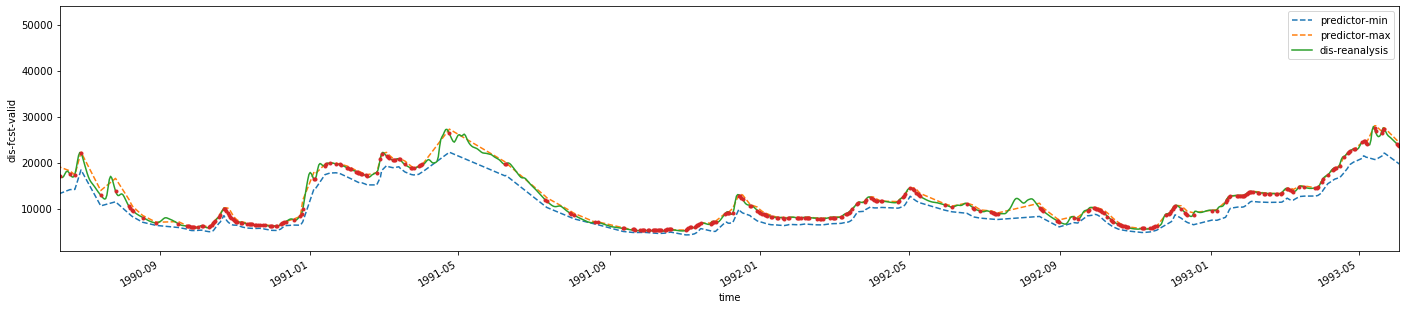

In [37]:
fig, ax = plt.subplots(figsize=(24,5))
minpred = add_time(Xda.min(axis=1), time)
maxpred = add_time(Xda.max(axis=1), time)

minpred.plot(ax=ax, linestyle='--', label='predictor-min')
maxpred.plot(ax=ax, linestyle='--', label='predictor-max')

dis[:,i,j].to_pandas().plot(ax=ax, label='dis-reanalysis')
y_valid_pred.plot(ax=ax, marker='.', lw=0)

plt.legend()
plt.gca().set_xlim(y_valid_pred.time.values[0], y_valid_pred.time.values[-1]) 